In [2]:
import sys
import stmpy
import numpy as np
from numpy import pi
import cancelv3 as cancel
from decimal import *
import matplotlib.pyplot as plt
from sklearn.externals import joblib
import pandas as pd
import scipy.fftpack as fftp
import os
from scipy import signal
import scipy
import time
from matplotlib import colors
import scipy.integrate as integrate
import scipy.special as special
%pylab inline

Populating the interactive namespace from numpy and matplotlib


(0, 100)

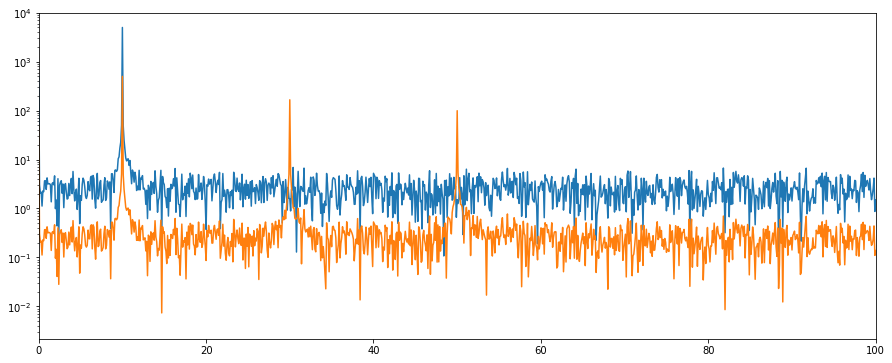

In [321]:
figsize(15,6)
fs = 1000
t= linspace(0,10,10*fs)

amp = 1
amp_convert = 0.1
noise = 1e-1*np.random.random(len(t))

# x = amp*np.sin(10*2*pi*t) + 10*np.sin(25*2*pi*t) 
# y = amp_convert*(np.copy(x) + amp*0.33333*np.sin(30*2*pi*t + 1*pi)) #+ amp*0.2*np.sin(50*2*pi*t + 0.25*pi))

x = np.sin(10*2*pi*t) + noise
y = amp_convert*(np.sin(10*2*pi*t) + 0.3333*np.sin(30*2*pi*t) + 0.2*np.sin(50*2*pi*t) + noise)

x_fft = np.fft.fft(x)
y_fft = np.fft.fft(y)
semilogy(freqs[:int(len(freqs)/2)],abs(x_fft[:int(len(freqs)/2)]))
semilogy(freqs[:int(len(freqs)/2)],abs(y_fft[:int(len(freqs)/2)]))
xlim(0,100)

In [322]:
def ref(w,t_array):
    return np.sin(w*2*pi*t_array)

def coef(w,geo,tip,t_array,harmonic):
    lock_coef = 1/(2*pi)
    
    ref_tip = np.sin(w*harmonic*2*pi*t) * tip
    ref_geo = np.sin(w*2*pi*t) * geo
    
    sos = signal.butter(10, w, 'lowpass', fs=fs, output='sos')
    filt_tip = signal.sosfilt(sos,ref_tip)
    filt_geo = signal.sosfilt(sos,ref_geo)
    
    
    lock_tip = integrate.trapz(t, filt_tip)
    lock_geo = integrate.trapz(t, filt_geo)
    mag = lock_tip/lock_geo
    
    return mag

amp = coef(11,x,y,t,1)
print(amp)

0.10013460638043399


In [329]:
freqs = np.fft.fftfreq(len(x),1/fs)
C_1 = np.zeros(len(freqs),dtype='complex128')
C_3 = np.zeros(len(freqs),dtype='complex128')
C_5 = np.zeros(len(freqs),dtype='complex128')
geo = signal.chirp(t,1,20,10)

for w in arange(int(len(freqs)/2)-1):
    w = w+1
    print(w,end='\r')
    C_1[w] = coef(freqs[w],x,y,t,1)
    C_3[w] = coef(freqs[w],x,y,t,3)
    C_5[w] = coef(freqs[w],x,y,t,5)

C_1[int(len(freqs)/2)+1:] = np.flip(C_1[1:int(len(freqs)/2)])
C_3[int(len(freqs)/2)+1:] = np.flip(C_3[1:int(len(freqs)/2)])
C_5[int(len(freqs)/2)+1:] = np.flip(C_5[1:int(len(freqs)/2)])




(0, 500)

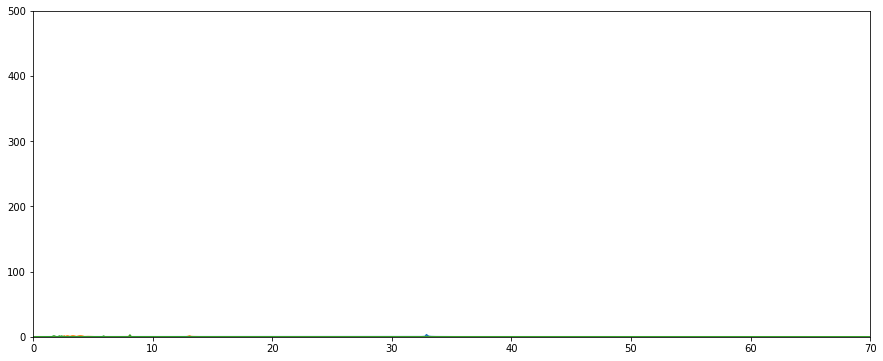

In [330]:


plot(freqs[:int(len(freqs)/2)],absolute(C_1[:int(len(freqs)/2)]))
plot(freqs[:int(len(freqs)/2)],absolute(C_3[:int(len(freqs)/2)]))
plot(freqs[:int(len(freqs)/2)],absolute(C_5[:int(len(freqs)/2)]))

xlim(0,70)
ylim(0,500)

In [331]:
C_1 = scipy.interpolate.interp1d(freqs,C_1,kind='linear')
C_3 = scipy.interpolate.interp1d(freqs,C_3,kind='linear')
C_5 = scipy.interpolate.interp1d(freqs,C_5,kind='linear')

(0, 2)

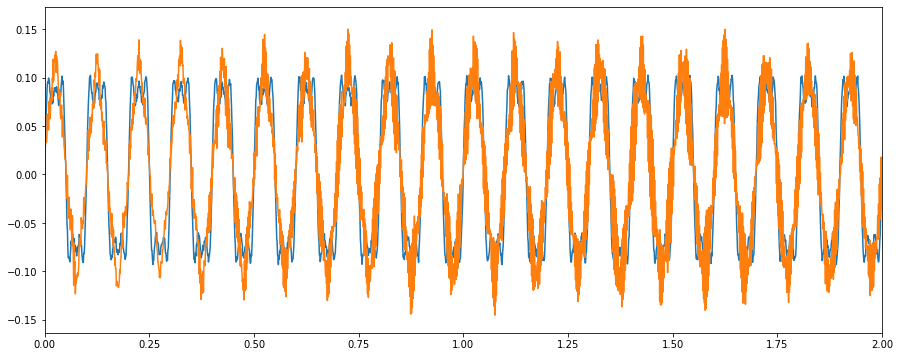

In [334]:

geo_m = scipy.interpolate.interp1d(freqs,x_fft,kind='linear')

mat_app = C_1(freqs)*geo_m(freqs) + C_3(freqs)*geo_m(freqs/3) + C_5(freqs)*geo_m(freqs/5) 
mat_wav = np.fft.ifft(mat_app)
plot(t,y)
plot(t,mat_wav)
xlim(0,2)

(400, 500)

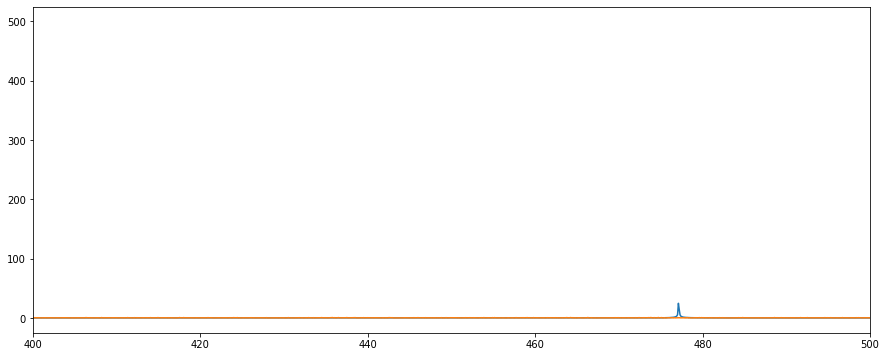

In [347]:
plot(freqs[:int(len(x_fft)/2)],abs(C_1(freqs)[:int(len(x_fft)/2)]))
plot(freqs[:int(len(x_fft)/2)],abs(y_fft[:int(len(x_fft)/2)]))
xlim(400,500)

In [204]:
# Use chirp signal as reference
# add chirp to "geo" 
# have a constant response at first
# Create a 90 degree phase shifted reference signal to also multiply response against
# Apply a low pass filter to both to reejct the 2w component
# the resulting amplitude is sqrt(X^2 + Y^2)
# the phase is arctan2(X,Y)

(0, 5)

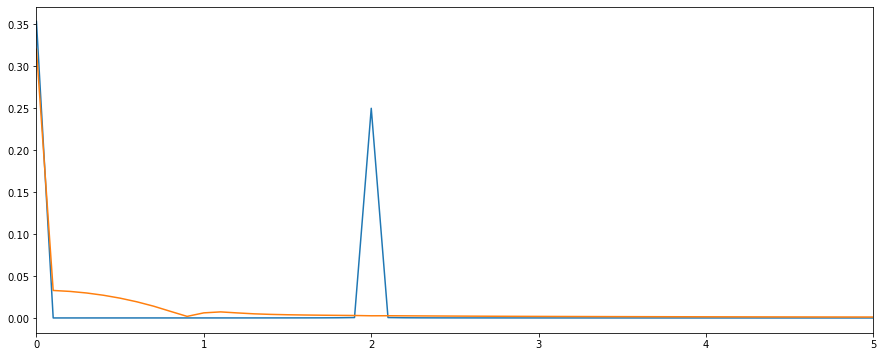

In [150]:
import math
x = np.sin(1*2*pi*t+0.25*pi)*np.sin(1*2*pi*t)
y = np.sin(10*2*pi*t + 0.5*pi)*np.sin(10*2*pi*t)
result= np.fft.fft(x)/len(x)
freqs = np.fft.fftfreq(len(x),1/fs)
sos = signal.butter(10, 1, 'lowpass', fs=fs, output='sos')
filtered = signal.sosfilt(sos, x)
result_filt= np.fft.fft(filtered)/len(x)
plot(freqs[:int(len(freqs)/2)],absolute(result[:int(len(freqs)/2)]))
plot(freqs[:int(len(freqs)/2)],absolute(result_filt[:int(len(freqs)/2)]))
xlim(0,5)


### Lock in Amplifier

In [152]:
start = 1
end = 10
sig = signal.chirp(t,start,10,end)
# ref_quad = signal.chirp(t,start,10,end,phi=90)
sig = np.sin(10*2*pi*t)
f = start + (end-start)*(t/10)
print(f[0],f[55])
print(t[0],t[55])

1.0 1.0495049504950495
0.0 0.05500550055005501


In [ ]:
count = 0
freqs = np.fft.fftfreq(len(sig),1/fs)
for w in freqs[:int(len(freqs)/2)]:
    i_step = count*50 + 50
    ref = np.sin(w*2*pi*t)
    ref_quad = np.sin(w*2*pi*t+0.5*pi)
    
    count = count+1

0.0047948193980828 0.0015982731326947151
[1.66822121 1.59814862 1.38739273 1.42109992 1.57812414 1.56020674
 1.44455881 1.4551014  1.53985443 1.53311699 1.47114971 1.47570588
 1.52096152 1.51777274 1.48474091 1.48701636 1.51111902 1.50947819
 1.49189362 1.49308338]


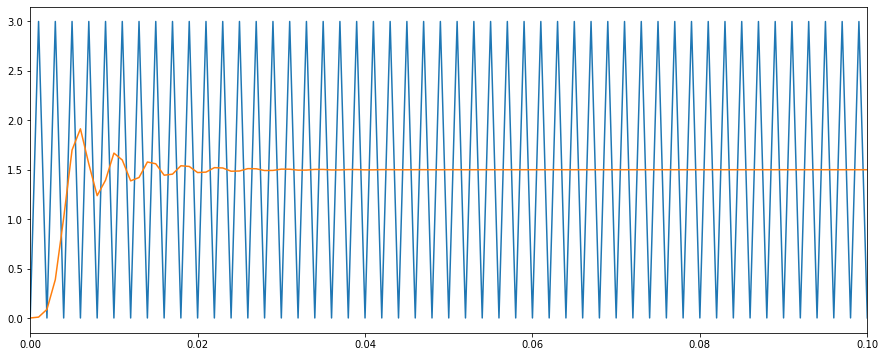

In [239]:
w = 250
harmonic = 1
ref_tip = 3*np.sin(w*harmonic*2*pi*t) * np.sin(w*2*pi*t)
ref_geo = np.sin(w*2*pi*t) * np.sin(w*2*pi*t)

sos = signal.butter(10, w, 'lowpass', fs=fs, output='sos')
filt_tip = signal.sosfilt(sos,ref_tip)
filt_geo = signal.sosfilt(sos,ref_geo)


lock_tip = integrate.trapz(t, filt_tip)
lock_geo = integrate.trapz(t, filt_geo)
print(lock_tip,lock_geo)

tip_fft = np.fft.fft(ref_tip)/len(ref_tip)
geo_fft = np.fft.fft(ref_geo)/len(ref_geo)
tip_filt_fft = np.fft.fft(filt_tip)/len(ref_tip)
geo_filt_fft = np.fft.fft(filt_geo)/len(ref_tip)
# plot(freqs[:int(len(tip_fft)/2)],tip_fft[:int(len(tip_fft)/2)])
# plot(freqs[:int(len(tip_fft)/2)],geo_fft[:int(len(tip_fft)/2)])
# plot(freqs[:int(len(tip_fft)/2)],tip_filt_fft[:int(len(tip_fft)/2)])
# plot(freqs[:int(len(tip_fft)/2)],geo_filt_fft[:int(len(tip_fft)/2)])
xlim(0,0.1)
plot(t,ref_tip)
plot(t,filt_tip)
print(filt_tip[10:30])
# plot(t,ref_geo)
